# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ensemble Learning 

"If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will  
often get better predictions than with the best individual predictor. A group of predictors  
is called an ensemble; thus, this technique is called Ensemble Learning, and an  
Ensemble Learning algorithm is called an Ensemble method."

"As discussed in Chapter 2, you will often use Ensemble methods near the end of a  
project, once you have already built a few good predictors, to combine them into an  
even better predictor."

# Voting Classifier

"A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classifier
is called a hard voting classifier (see Figure 7-2)."

![title](images/voting_classifier_1.png)
![title](images/voting_classifier_2.png)

"Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the  
best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning  
it does only slightly better than random guessing), the ensemble can still be a  
strong learner (achieving high accuracy), provided there are a sufficient number of  
weak learners and they are sufficiently diverse."

TIP:"Ensemble methods work best when the predictors are as independent  
from one another as possible. One way to get diverse classifiers  
is to train them using very different algorithms. This increases the  
chance that they will make very different types of errors, improving  
the ensemble’s accuracy."

In [15]:
heads_proba = 0.51
# Note: np.random.rand(10000, 10) return an array of 10 columns and 10,000 rows where each number is x < 1
# np.random.rand(10000, 10) < heads_proba makes a boolean so the array is an array of 1's and 0's
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
print("Coin Tosses: ")
print(coin_tosses)
# Note: np.cumsum(coin_tosses, axis = 0) performs the cumulative sum over the rows
# Np.arrange(1, 10001) creates an array from 1 - 10,000
# .reshape(-1,1) converts the array to a array of 10,000 rows and 1 column
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
print("Cumulative Sum")
print(np.cumsum(coin_tosses, axis=0))
print("Np Arrange")
print(np.arange(1, 10001).reshape(-1,1))
print("Np Arrange with Reshape")
print(np.arange(1, 10001).reshape(-1, 1))
print("Cumulative Head Ratio")
print(cumulative_heads_ratio)

Coin Tosses: 
[[0 0 0 ... 1 1 0]
 [0 1 1 ... 1 0 1]
 [1 1 1 ... 0 1 1]
 ...
 [1 0 1 ... 1 1 1]
 [0 0 0 ... 0 1 1]
 [1 1 1 ... 1 0 0]]
Cumulative Sum
[[   0    0    0 ...    1    1    0]
 [   0    1    1 ...    2    1    1]
 [   1    2    2 ...    2    2    2]
 ...
 [5036 5092 5134 ... 5148 5090 5074]
 [5036 5092 5134 ... 5148 5091 5075]
 [5037 5093 5135 ... 5149 5091 5075]]
Np Arrange
[[    1]
 [    2]
 [    3]
 ...
 [ 9998]
 [ 9999]
 [10000]]
Cumulative Sum / Np Arrange
[[    1]
 [    2]
 [    3]
 ...
 [ 9998]
 [ 9999]
 [10000]]
Cumulative Head Ratio
[[0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.5        0.5        ... 1.         0.5        0.5       ]
 [0.33333333 0.66666667 0.66666667 ... 0.66666667 0.66666667 0.66666667]
 ...
 [0.50370074 0.50930186 0.5135027  ... 0.51490298 0.50910182 0.5075015 ]
 [0.50365037 0.50925093 0.51345135 ... 0.51485149 0.50915092 0.50755076]
 [0.5037     0.5093     0.5135     ... 0.5149     0.5091     0.5075    ]

Saving figure law_of_large_numbers_plot


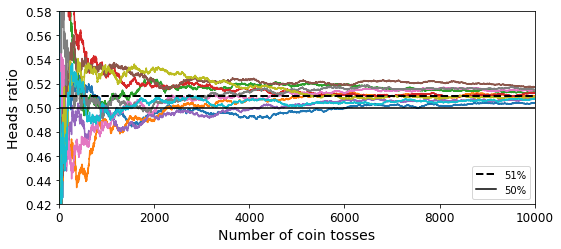

In [16]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [19]:
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [25]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


"There you have it! The voting classifier slightly outperforms all the individual classifiers."

"If all classifiers are able to estimate class probabilities (i.e., they all have a predict_proba() method),  
then you can tell Scikit-Learn to predict the class with the  
highest class probability, averaged over all the individual classifiers. This is called soft  
voting. It often achieves higher performance than hard voting because it gives more  
weight to highly confident votes. All you need to do is replace voting="hard" with  
voting="soft" and ensure that all classifiers can estimate class probabilities. This is  
not the case for the SVC class by default, so you need to set its probability hyperparameter  
to True (this will make the SVC class use cross-validation to estimate class  
probabilities, slowing down training, and it will add a predict_proba() method). If  
you modify the preceding code to use soft voting, you will find that the voting classifier  
achieves over 91.2% accuracy!"

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability = True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92
